<a href="https://colab.research.google.com/github/maxbentley/datasciencefund/blob/main/Unit5/Max_Bentley_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [2]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [ ]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [ ]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

**Answer 1**

<Axes: xlabel='FT%', ylabel='FG%'>

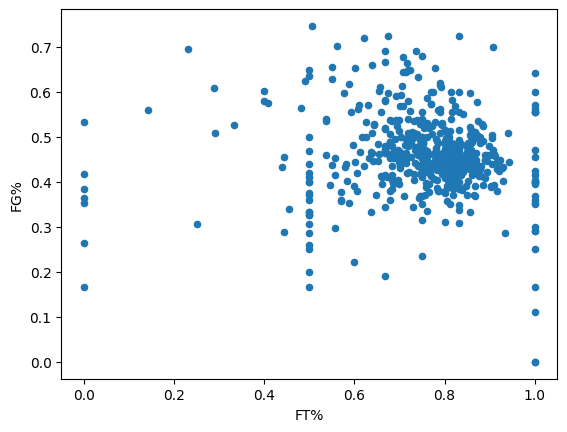

In [ ]:
basketball.plot.scatter('FT%','FG%')

There are a bunch of players that have a 100%, 50% or 0% FT rate, probably because they suffer from a low sample, and so only have like 2 NBA FTA to their name because they hadn't played at all in a serious capacity. The vast majority of the data seems to be clumped from 60-90% FT accuracy and 35%-55% FG accuracy, like in the good-sample model. I think the lower bound is a good estimate for the floor, since if players are any worse than those percentages they simply will not receive any playing time. There could be players with >90% FT or >55% FG accuracies, since being larger than that would constitute "elite" play, and so will receive more playing time.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

**Answer 2**

In [ ]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = basketball.Pos.cat.codes.values

#an array of the strings that represent position
pos_codes = basketball.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bb_coords = {"pos": pos_codes}

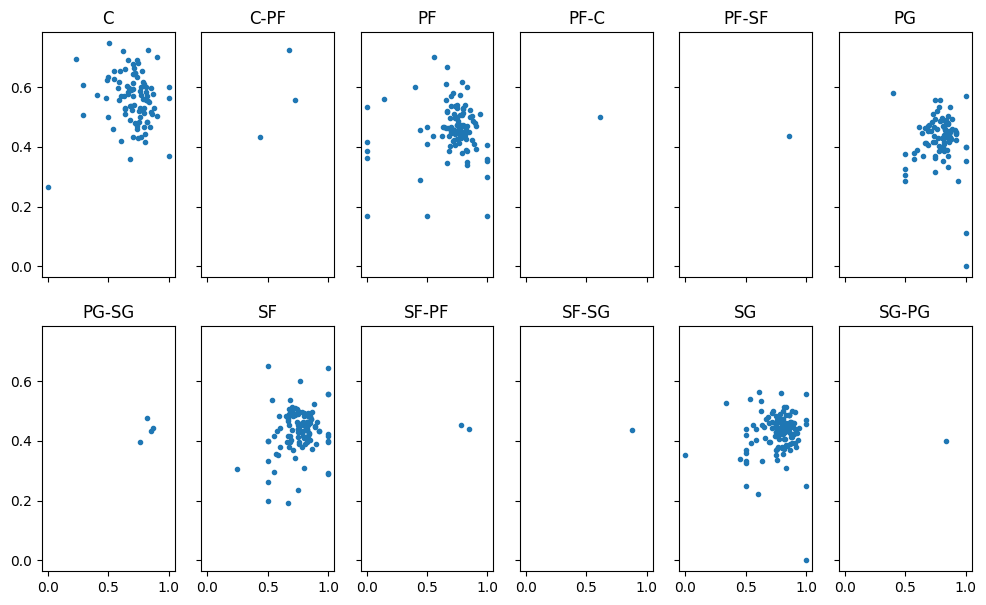

In [ ]:
#set up the 12 plots
_, ax = plt.subplots(2, 6, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

**Answer 3**

There doesn't seem to be much of a linear relationship in the data, unlike the regular dataset. The negative trend found in the point forward and center positions are still there, but less so because of the low-sample outliers. Therefore, a linear regression model makes no sense to the computer, because the computer believes that this is basically just noise. Additionally, the large amount of variance in FG% at the exact same FT% probably makes the markov chains shoot themselves.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [3]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [ ]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

<Axes: xlabel='height', ylabel='weight'>

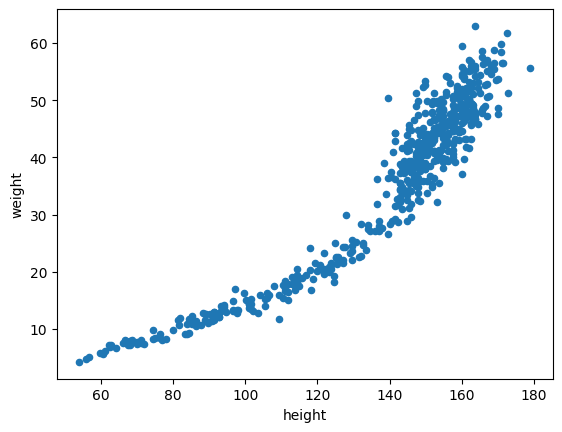

In [ ]:
# Answer 4

howell.plot.scatter('height','weight')

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [28]:
# Answer 5

# model
with pm.Model() as howell_straight:

    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_howstr = pm.sample()

Output()

Output()

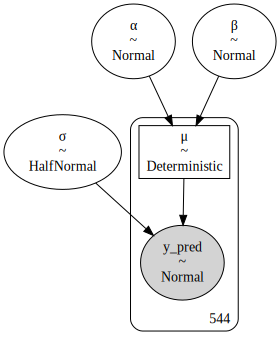

In [ ]:
pm.model_to_graphviz(howell_straight)

Text(0, 0.5, 'length')

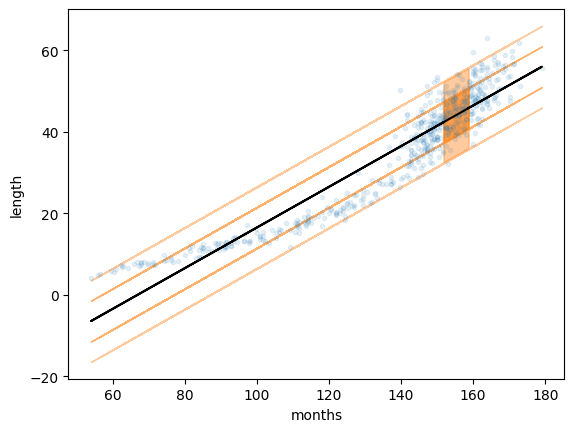

In [29]:
# plots the posterior

_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.1)

posterior_howstr = az.extract(idata_howstr)

μ_m = posterior_howstr["μ"].mean("sample").values
σ_m = posterior_howstr["σ"].mean("sample").values

ax.plot(howell.height, μ_m, c="k")
ax.fill_between(howell.height, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.height, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("months")
ax.set_ylabel("length")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [ ]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_howstr, model = howell_straight, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

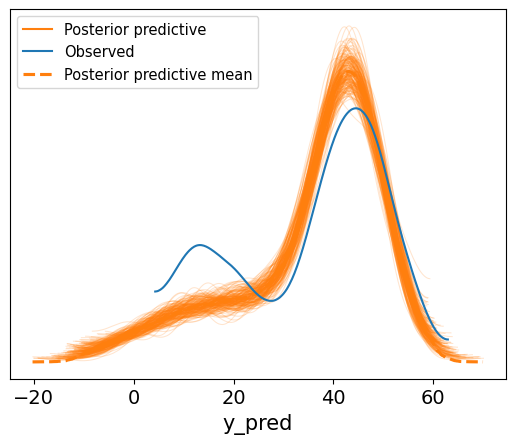

In [ ]:
# posterior predictive check
az.plot_ppc(idata_howstr, num_pp_samples=200, colors=["C1", "C0", "C1"])

The shape of the data for the upper 60% matches it pretty well, but outside of that, the fit is terrible. The mode is far off, there's a huge spike thing that the model does not pick up on at all, and generally it's just not great.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [24]:
# Answer 7

# model
with pm.Model() as howell_exp:

    # weights prior

    #priors for our mean line
    α = pm.Normal("α", sigma=1)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", pm.math.exp(α + β * howell.height))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_howexp = pm.sample()

Output()

Output()

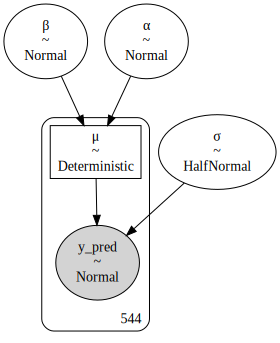

In [10]:
pm.model_to_graphviz(howell_exp)

In [25]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(idata_howexp, model = howell_exp, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

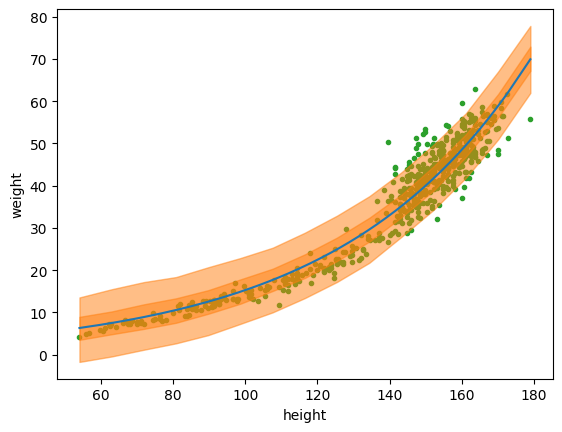

In [26]:
# plots the posterior

mean_line = idata_howexp.posterior["μ"].mean(("chain", "draw"))
heights = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(heights)
x = np.linspace(heights.min(), heights.max(), 15)
y_pred_q = idata_howexp.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(heights[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

Output()

<Axes: xlabel='y_pred'>

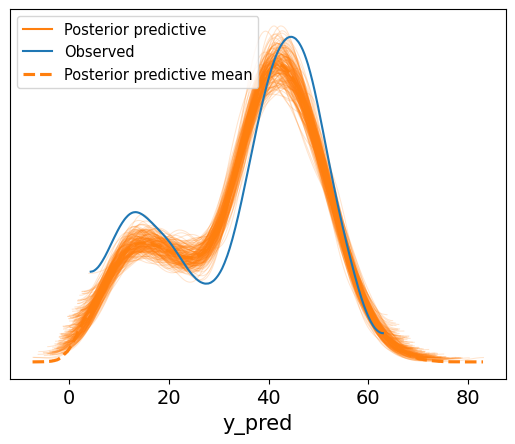

In [27]:
# posterior predictive check
pm.sample_posterior_predictive(idata_howexp, model = howell_exp, extend_inferencedata=True)

az.plot_ppc(idata_howexp, num_pp_samples=200, colors=["C1", "C0", "C1"])

This fit is... better, but still not great. It matches the shape of the graph well, but undershoots and overshoots the data at many points, mostly on the first mode. The second mode also is shifted a little to the left. It's better than the regular linear regression, though.